In [1]:
import pandas as pd
from tabulate import tabulate
from scipy.stats import ttest_ind
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
pd.set_option('display.max_columns', None)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
play2024_df = pd.read_csv("data/play_by_play_2024.csv")
injury2024_df = pd.read_csv("data/injuries_2024.csv")

/var/folders/rx/0shr4jt1365bgrnlk6fkmjjh0000gn/T/ipykernel_94377/865703963.py:1: DtypeWarning: Columns (179,180,182,183,189,190,197,198,203,204,205,206,222,224,226,233,234,235,236,237,238,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  play2024_df = pd.read_csv("data/play_by_play_2024.csv")


In [3]:
def first_last_a(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0]}.{parts[1]}"

In [4]:
def first_last_b(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0:2]}.{parts[1]}"

In [5]:
warnings.filterwarnings('ignore')

def merge_play_injury_dfs(play_df, injury_df):

    # preprocessing
    injury_df["date"] = pd.to_datetime(injury_df['date_modified'])
    play_df["date"] = pd.to_datetime(play_df['game_date'])
    injury_df['date'] = injury_df['date'].dt.tz_localize(None)
    play_df['date'] = play_df['date'].dt.tz_localize(None)

    # filtering
    plays_with_injuries = play_df[play_df['desc'].str.contains("was injured", na=False)]
    pattern = r'(\w+\.(?:\w|-|\.|\')+(?: \w+)*) was injured'
    # Extract the injured player's name from the desc column
    injured_players = plays_with_injuries.loc[:, "desc"].str.extract(pattern)

    # concatenation
    plays_with_injuries = pd.concat([plays_with_injuries, injured_players], axis=1)
    plays_with_injuries.rename(columns={0: "injured_player"}, inplace=True)
    plays_with_injuries = plays_with_injuries.reset_index(drop=True)
    
    # merging
    injuries = []
    for (week, team), group_injury_df in injury_df.groupby(['week', 'team']):
        group_play_df = plays_with_injuries[(plays_with_injuries['week'] == week) & ((plays_with_injuries['home_team'] == team) | (plays_with_injuries['away_team'] == team))]

        group_injury_df = group_injury_df[group_injury_df.date >= group_play_df.date.max()]

        group_injury_df["first_type"] = group_injury_df['full_name'].apply(first_last_a)
        group_injury_df["second_type"] = group_injury_df['full_name'].apply(first_last_b)

        x = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="first_type", how="inner")
        y = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="second_type", how="inner")

        injuries.append(pd.concat([x, y], axis = 0, ignore_index=True))

    plays_with_injuries_and_injury_record = (pd.concat(injuries, axis=0, ignore_index=True)).drop(columns=["first_type", "second_type"])
    plays_with_injuries_and_injury_record = plays_with_injuries_and_injury_record.sort_values('play_id', ascending=False).drop_duplicates(subset=['week_x', 'full_name', "team"], keep='first')

    return plays_with_injuries, plays_with_injuries_and_injury_record
#returns (plays where injuries occurred, plays were injuries occurred and missed time)



In [6]:
def populate_cols_in_play_df(play_df, plays_with_injuries, plays_with_injuries_and_injury_record):
    columns_to_check = ['play_id', 'game_id']
    play_df["was_injured"] = 0
    play_df["missed_time"] = 0
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries[columns_to_check].apply(tuple, 1)), 'was_injured'] = 1
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries_and_injury_record[columns_to_check].apply(tuple, 1)), 'missed_time'] = 1

    return play_df

In [7]:
plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024 = merge_play_injury_dfs(play2024_df, injury2024_df)


In [8]:
# Print number of rows for each returned table
print("Rows in plays_with_injuries_2024:", len(plays_with_injuries_2024))
print("Rows in plays_with_injuries_and_injury_record_2024:", len(plays_with_injuries_and_injury_record_2024))


Rows in plays_with_injuries_2024: 457
Rows in plays_with_injuries_and_injury_record_2024: 185


In [9]:
play2024_df = populate_cols_in_play_df(play2024_df, plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024)

### MODELING 

In [10]:
# dropping meta data columns
play2024_df = play2024_df.drop(columns=["play_id","game_id","old_game_id"])

In [11]:
numeric_columns = play2024_df.select_dtypes(include=['number']).columns

In [12]:
play2024_df = play2024_df.fillna("missing")

In [13]:
# converting categorical data into numeric

categorical_cols = play2024_df.select_dtypes(include=['object']).columns.tolist()
label_encoder = LabelEncoder()

for col in categorical_cols:
    if play2024_df[col].dtype == 'object':
        play2024_df[col] = label_encoder.fit_transform(play2024_df[col].astype(str))

play2024_df['date'] = pd.to_datetime(play2024_df['date'])

play2024_df['game_month'] = play2024_df['date'].dt.month
play2024_df['game_day'] = play2024_df['date'].dt.day

# Drop the original 'game_date' column if not needed
play2024_df = play2024_df.drop(columns=['date'])

In [14]:
# dimensionality reduction

# Apply PCA to reduce dimensions
pca = PCA(n_components=0.99, svd_solver="full") 
# Separate features (X) and target (y)
X = play2024_df.drop(columns=['was_injured', "missed_time"])  # Drop the target column
y = play2024_df['was_injured']  # Target column
# Split the data
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [15]:
# Apply SMOTE to oversample the minority class
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Apply PCA (as you are already doing) on X_train and X_test
# Note: Apply PCA after SMOTE for consistency
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

print(f"Original dataset class distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"Resampled dataset class distribution: {dict(zip(*np.unique(y_train_resampled, return_counts=True)))}")

Original dataset class distribution: {0: 23299, 1: 411}
Resampled dataset class distribution: {0: 23299, 1: 23277}


Confusion Matrix:
[[1466 1123]
 [  18   28]]
Accuracy: 0.57
              precision    recall  f1-score   support

           0       0.99      0.57      0.72      2589
           1       0.02      0.61      0.05        46

    accuracy                           0.57      2635
   macro avg       0.51      0.59      0.38      2635
weighted avg       0.97      0.57      0.71      2635



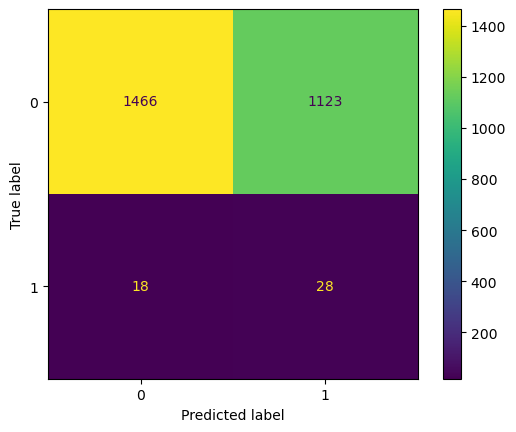

In [16]:

# Initialize XGBoost model
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    learning_rate=0.01,
    max_depth=6,
    gamma=1,
    min_child_weight=5,
    scale_pos_weight=1
)

# Train the model
model.fit(X_train_pca, y_train_resampled)

# Predict on the test set
y_pred = model.predict(X_test_pca)
y_proba = model.predict_proba(X_test_pca)[:, 1]
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()  # You can customize the color map if needed

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[1646  943]
 [  18   28]]


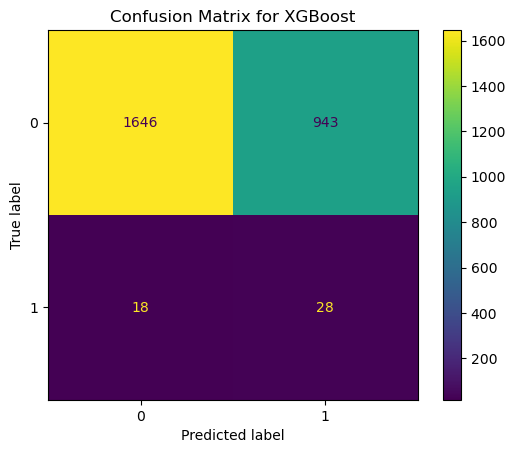

Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.99      0.64      0.77      2589
           1       0.03      0.61      0.06        46

    accuracy                           0.64      2635
   macro avg       0.51      0.62      0.41      2635
weighted avg       0.97      0.64      0.76      2635



In [18]:
threshold = 0.521

# Convert probabilities to binary predictions based on the threshold
y_pred = (y_proba >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()  # You can customize the color map if needed
plt.title("Confusion Matrix for XGBoost")  # Set the title here
plt.show()

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred))

### report stuff

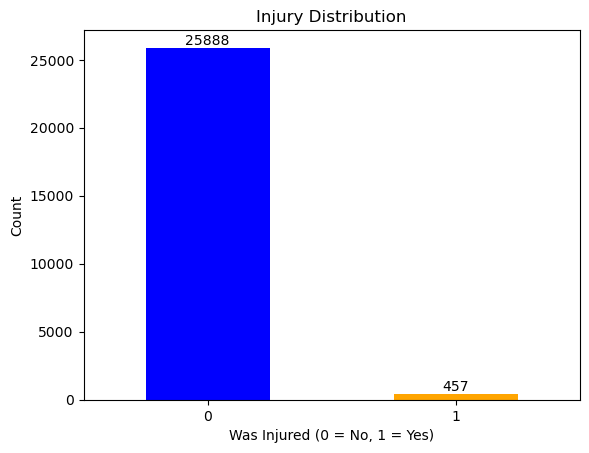

In [19]:
counts = play2024_df["was_injured"].value_counts()
ax = counts.plot.bar(color=["blue", "orange"])

# Add frequency numbers on top of each bar
for bar in ax.patches:
    ax.annotate(
        str(bar.get_height()),  # The frequency value
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position: center of the bar
        ha='center', va='bottom'  # Center alignment
    )

# Customize the chart
plt.title("Injury Distribution")
plt.xlabel("Was Injured (0 = No, 1 = Yes)")
plt.ylabel("Count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Set x-axis labels horizontal
plt.show()

In [20]:
pca_importance = model.feature_importances_

In [21]:
pca_components = pca.components_

# Compute contribution of original features
original_feature_importance = np.abs(pca_components.T @ pca_importance)

# Step 3: Rank original features
# Assuming `feature_names` contains names of the original features
feature_names = X.columns  # Replace with your feature names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': original_feature_importance
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Top 5 features
top_5_features = importance_df.head(5)
print(top_5_features)

          Feature  Importance
97   away_wp_post    0.114723
290   time_of_day    0.112206
98       vegas_wp    0.110322
89             wp    0.080966
90         def_wp    0.076430


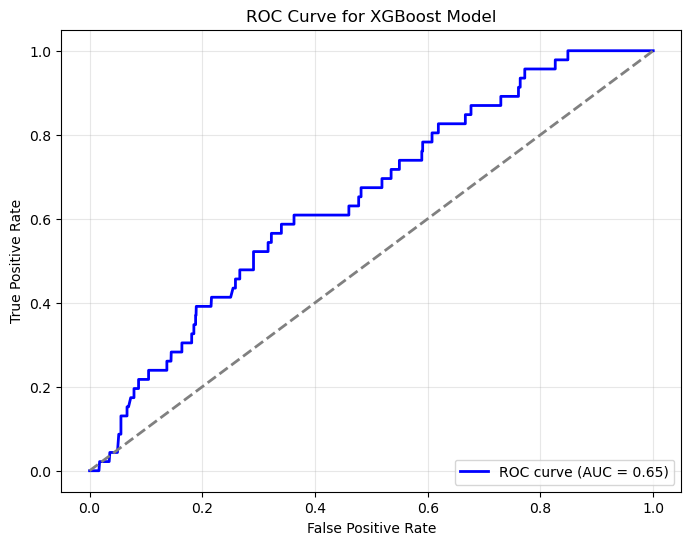

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()